In [17]:
import torch
print(torch.__version__)

2.1.0+cu121


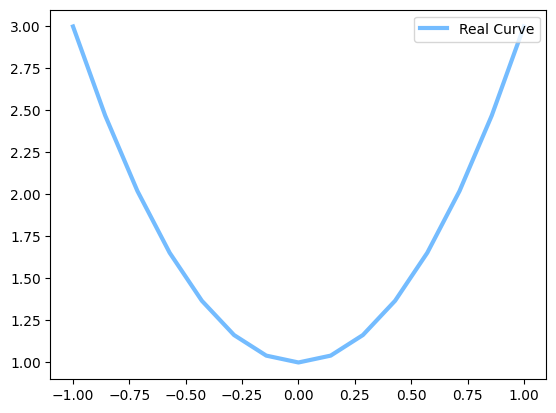

In [73]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 64
G_IN_SIZE = 15 #生成器输入 尺寸
G_OUT_SIZE = 15 #生成器输出 尺寸

PAINT_POINTS = np.vstack([np.linspace(-1,1, G_OUT_SIZE) for _ in range(BATCH_SIZE)]) #shape (BATCH_SIZE, G_OUT_SIZE)

plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='Real Curve')    #2 * x^2 + 1
plt.legend(loc='upper right') #标签位置
plt.show()

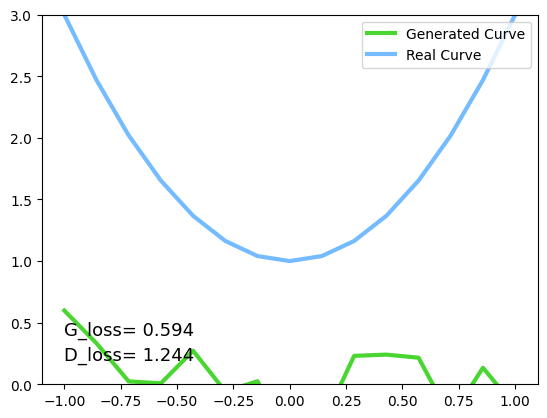

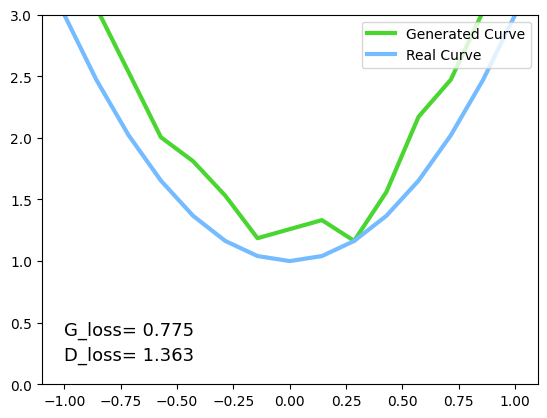

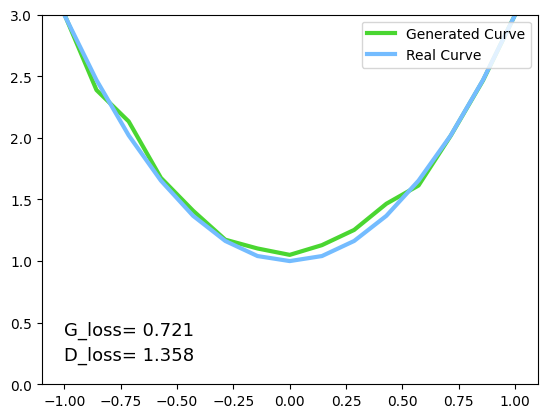

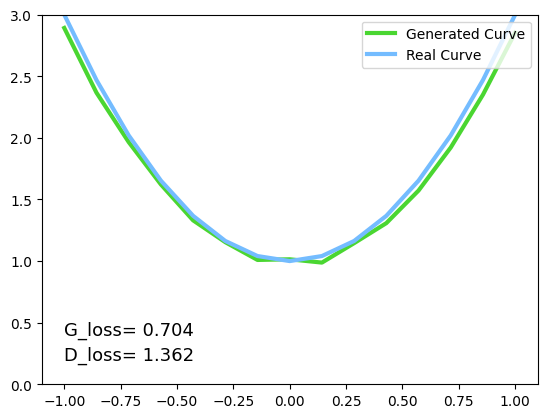

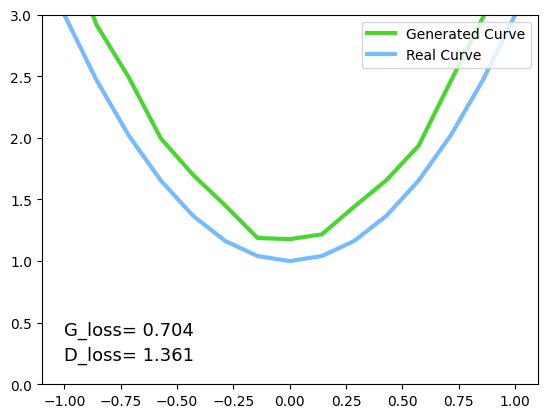

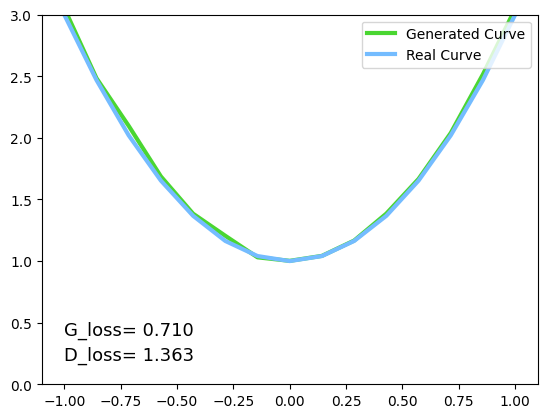

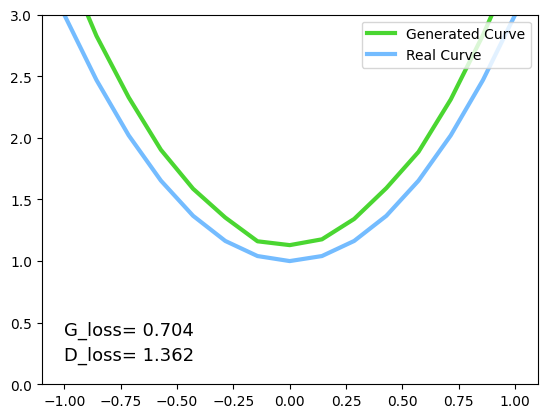

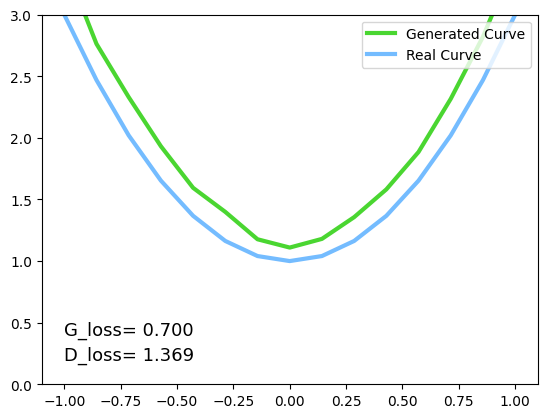

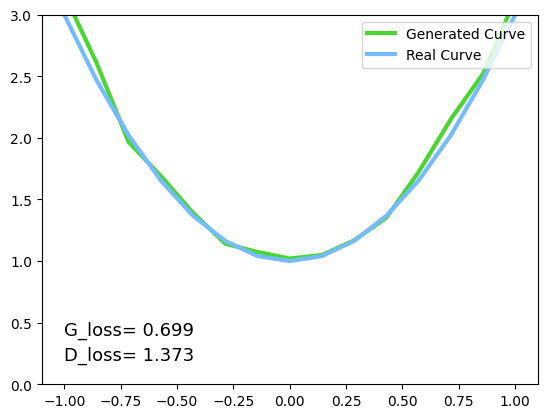

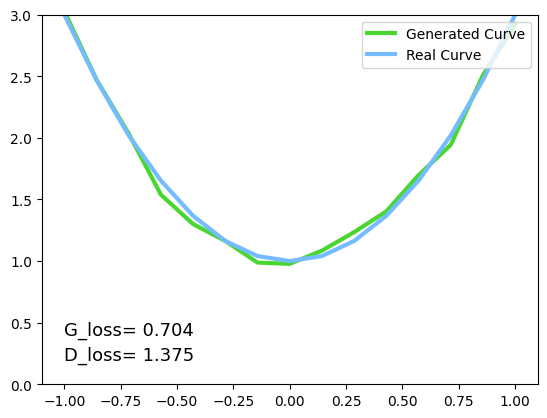

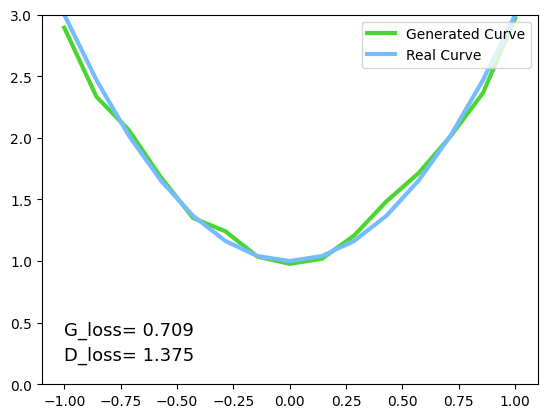

In [74]:
# 准备数据
def real_points():
    paints = 2 * np.power(PAINT_POINTS,2) + 1
    paints = torch.from_numpy(paints).float()
    return paints

#定义网络
G = nn.Sequential(
    nn.Linear(G_IN_SIZE,128),
    nn.ReLU(),
    nn.Linear(128,G_OUT_SIZE)
)

D = nn.Sequential(
    nn.Linear(G_OUT_SIZE,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()            #0为False，1为True  D的评估应该是在【0-1】之间的数值，所以这里采用的是Sigmod激活
)

# 优化函数
optimizer_G = torch.optim.Adam(G.parameters(),lr=0.0001)
optimizer_D = torch.optim.Adam(D.parameters(),lr=0.0001)

bceloss = nn.BCELoss()

#训练
for step in range(10001):
    real_data = real_points() # 生成真实数据
    # print('real_data', real_data.shape)
    randn_input = torch.randn(BATCH_SIZE, G_IN_SIZE) #输入噪声
    # print('randn_input', randn_input.shape)

    eps = 1e-6  #防止log 0
    
    D_real = D(real_data) # 0为False，1为True，这里输入真实数据，D_real越靠近1越好
    D_fake = D(G(randn_input))
    
    #训练判别器D，根据公式 D_loss 分为两个部分：判断真实数据 log(1-D_real)；判断假数据 log(D_fake) 
    # D带着G一起更新，使用D(G(input))
    # D_loss = -torch.mean(torch.log(eps + 1.0 - D_real) + torch.log(eps + D_fake))
    D_loss = bceloss(1-D_real, torch.ones_like(D_real)) + bceloss(1-D_fake, torch.zeros_like(D_fake))
    
    optimizer_D.zero_grad()
    D_loss.backward()
    optimizer_D.step()

    #训练生成器G
    G_fake_out = G(randn_input) # 生成器生成假数据
    D_fake = D(G_fake_out) # 用判别器判别假数据，最好能让判别器判断概率趋近0.5，即生成器生成的假数据，能让判别器真假难辨
    # G的损失 越接近1越好，当D_fake->0.5时，G_loss=log(1-0.5)=0.6931..., 此时 D_loss=log(1-0.5)+log(0.5)= 1.3832...
    # G_loss = -torch.mean(torch.log(1.0 - D_fake + eps))
    G_loss = bceloss(D_fake, torch.zeros_like(D_fake))
    
    optimizer_G.zero_grad()
    G_loss.backward() #反向
    optimizer_G.step() #更新G参数
        
    if step % 1000 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_fake_out.data.numpy()[0], c='#4AD631', lw=3, label='Generated Curve',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='Real Curve')
        plt.text(-1.0, 0.4, 'G_loss= %.3f ' % G_loss.data.numpy(), fontdict={'size': 13})
        plt.text(-1.0, 0.2, 'D_loss= %.3f ' % D_loss.data.numpy(), fontdict={'size': 13})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.1)



当判别器真假难辨时，D_loss = log(0.5) = 0.6931... 
损失函数值到理论值附近时，合成数据依旧没有达到训练预期效果，GAN网络的损失函数值并不能直接表示模型的训练程度。

从下图可以看到合成数据的分布，明显不是正态分布，因此这就引入了GAN模型的另外一个问题：损失函数值收敛到理论值附近，但合成出的结果与原始分布不同。这进一步可以说明经典GAN网络的损失函数无法准确地描述出真实数据和合成数据分布之间的不同，需要更优的损失函数来训练模型。


继续上述实验，将训练次数加多，损失函数值如下图，可以看出损失函数值依旧在0.693附近震荡。

此时合成数据分布接近正态；因此当损失函数值达到理论状态后并不表明合成的过程完成了，依旧需要大量的训练才能接近真实数据分布。

经典GAN模型生成器G与判别器D训练不同步，若真实分布与生成分布的相交部分测度为零，那么JS 散度恒为常数。真实分布与生成分布近似不相交或者完全不相交时JS 散度都是常数。因此JS 散度无法指示不重合的两个分布到底距离多远。W 距离随分布间“距离”的变化是连续的，会随分布间“距离”的增加而不断增大。